In [41]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

import numpy as np

In [42]:
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [43]:
import matplotlib.pyplot as plt

In [44]:
import warnings
warnings.filterwarnings('ignore')

## Tool Functions

In [45]:
from qiskit.quantum_info import DensityMatrix, Statevector, Operator

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

### - dagger and tensor 

In [46]:
state_0 = np.array([1, 0])
state_1 = np.array([0, 1])

In [47]:
from functools import reduce

Dag = lambda matrix: matrix.conj().T
Kron = lambda *matrices: reduce(np.kron, matrices)

### - pretty print

In [48]:
def pm(matrix):
    for row in range(len(matrix)):
        for col in range (len(matrix[row])):
            print("{:.3f}".format(matrix[row][col]), end = " ")
        print()

# 1. Find <3> in 2-qubits database

In [49]:
# https://qiskit.org/textbook/ch-algorithms/grover.html

## 1.1 set up starting state

In [50]:
def initCircuit(n):
    circuit = QuantumCircuit(n, n)
    
    for i in range(n):
        circuit.h(i)    
    circuit.barrier()
    
    return circuit

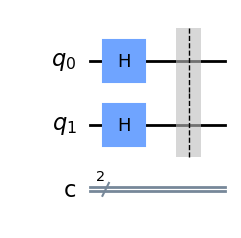

In [51]:
inputCircuit_2q = initCircuit(2)
inputCircuit_2q.draw(output='mpl')

## 1.2 creating Oracle for n=3

In [52]:
def createOracle_3():
    circuit = QuantumCircuit(2, 2)

    # Oracle for find 3

    # U_f 
    circuit.cz(0, 1)
    circuit.barrier()
    
    return circuit

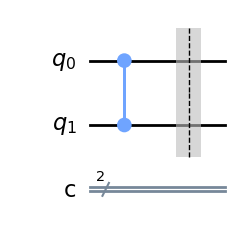

In [53]:
oracleCircuit_3 = createOracle_3()
oracleCircuit_3.draw(output='mpl')

### - test Oralce

In [54]:
O_3 = Operator(oracleCircuit_3).data
pm(O_3)

1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j -1.000+0.000j 


In [55]:
# all possible states
state_00 = Kron(state_0, state_0)
state_01 = Kron(state_0, state_1)
state_10 = Kron(state_1, state_0)
state_11 = Kron(state_1, state_1)

In [56]:
print("O|00>", O_3 @ state_00)
print("O|01>", O_3 @ state_01)
print("O|10>", O_3 @ state_10)
print("O|11>", O_3 @ state_11) # flip phase

O|00> [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
O|01> [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
O|10> [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
O|11> [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]


## 1.3 Diffuser

In [57]:
# H R H, where R = 2|0><0| - I 

### 1.3.1 R = 2|0><0| - I  (Conditional phase shift gate)

In [58]:
def createR_2q():
    circuit = QuantumCircuit(2, 2)
    
    circuit.z(0)
    circuit.z(1)
    circuit.cz(0, 1)
    
    return circuit

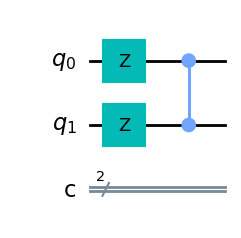

In [59]:
R_2q = createR_2q()
R_2q.draw(output='mpl')

### - test R

In [60]:
R_2q = Operator(R_2q).data
pm(R_2q)

1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j -1.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j -1.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j -1.000+0.000j 


In [61]:
# flip phase(no work on zero states) => Conditional Phase Shift gate
print("RO|00>", R_2q @ O_3 @ state_00) # zero state => would not flip
print("RO|01>", R_2q @ O_3 @ state_01)
print("RO|10>", R_2q @ O_3 @ state_10)
print("RO|11>", R_2q @ O_3 @ state_11)

RO|00> [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
RO|01> [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
RO|10> [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
RO|11> [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


### 1.3.2 diffuser circuit

In [62]:
# H R H

In [63]:
def createDiffuser_2q():
    circuit = QuantumCircuit(2, 2)
    
    circuit.h(0)
    circuit.h(1)
    circuit = circuit.compose(createR_2q())
    circuit.h(0)
    circuit.h(1)
    circuit.barrier()
    
    return circuit

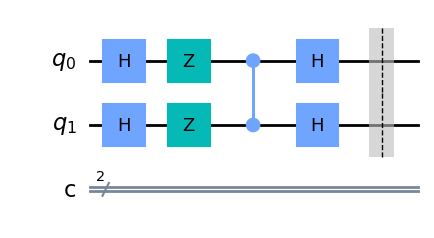

In [64]:
diffuserCircuit_2q = createDiffuser_2q()
diffuserCircuit_2q.draw(output='mpl')

### - test diffuser

In [65]:
diff_2q = Operator(diffuserCircuit_2q).data
pm(diff_2q)

-0.500+0.000j 0.500+0.000j 0.500+0.000j 0.500+0.000j 
0.500+0.000j -0.500+0.000j 0.500+0.000j 0.500+0.000j 
0.500+0.000j 0.500+0.000j -0.500+0.000j 0.500+0.000j 
0.500+0.000j 0.500+0.000j 0.500+0.000j -0.500+0.000j 


In [66]:
DB = 0.5 * state_00 + 0.5 * state_01 + 0.5 * state_10 + 0.5 * state_11
print("DO|DB>", diff_2q @ O_3 @ DB)

DO|DB> [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


## 1.4 Grover iteration

In [67]:
def createGroverIteration(oracle, diffuser):
    return oracle.compose(diffuser)

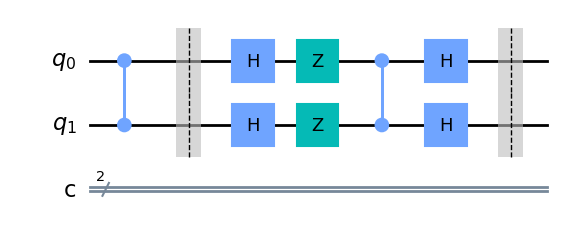

In [68]:
groverIteration_2q = createGroverIteration(createOracle_3(), createDiffuser_2q())
groverIteration_2q.draw(output='mpl')

## 1.5 Measure

In [69]:
groverIteration_2q = createGroverIteration(createOracle_3(), createDiffuser_2q())

### 1.5.1 one grover iteration

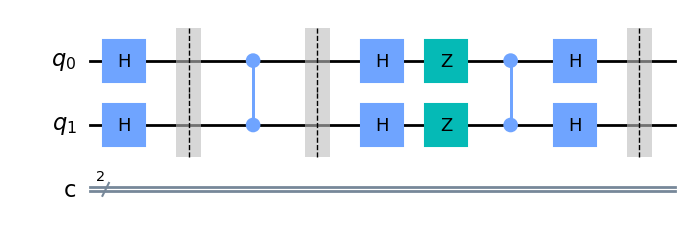

In [70]:
grover_2q_1 = initCircuit(2).compose(groverIteration_2q.copy())
grover_2q_1.draw(output='mpl')

In [71]:
grover_2q_1.measure([0, 1], [0, 1])

In [72]:
job = execute(grover_2q_1, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_2q_1)
print(counts)

{'11': 10000}


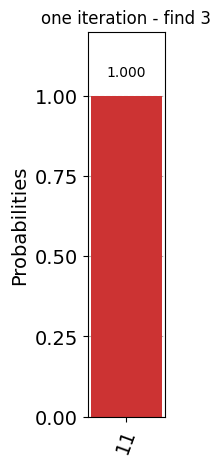

In [73]:
plot_histogram(counts, figsize=(1, 5), color="#CC3333", title="one iteration - find 3")

### 1.5.2 two grover iteration

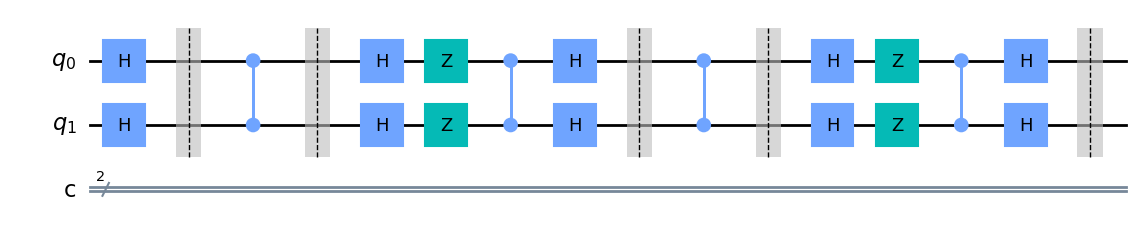

In [74]:
grover_2q_2 = initCircuit(2).compose(groverIteration_2q.copy()).compose(groverIteration_2q.copy())
grover_2q_2.draw(output='mpl')

In [75]:
grover_2q_2.measure([0, 1], [0, 1])

In [76]:
job = execute(grover_2q_2, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_2q_2)
print(counts)

{'11': 2440, '10': 2540, '01': 2538, '00': 2482}


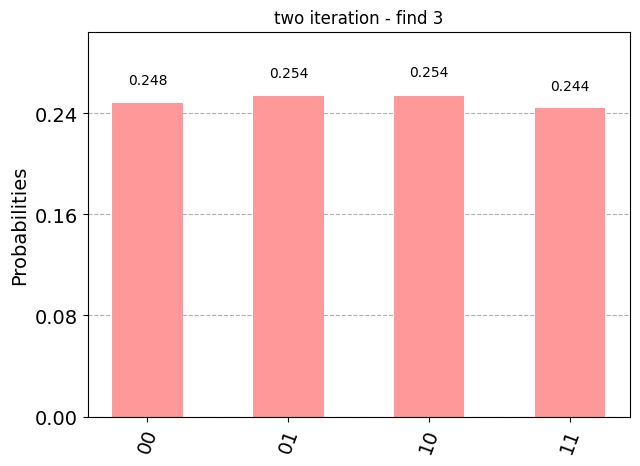

In [77]:
plot_histogram(counts, figsize=(7, 5), color="#FF9999", title="two iteration - find 3")